In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt 
import cv2 as cv 
import tensorflow

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from IPython.display import Image, display

In [ ]:
model = load_model("ModelFaceRecognition.h5")

In [ ]:
feature_extractor_model = Model(inputs=model.input, outputs=model.get_layer(index=-2).output)

In [ ]:
# Função para extrair vetores descritores para uma imagem
def extract_descriptor(image_path):
    img = cv.imread(image_path)
    img = cv.resize(img, (112, 112))
    img = img / 255.0  # Normalizar
    img = np.expand_dims(img, axis=0)  # Adicionar dimensão de lote
    descriptor = feature_extractor_model.predict(img)
    return descriptor.flatten()

# Diretório do conjunto de dados
dataset_dir = '/content/post-processed'

# Dicionário para armazenar vetores descritores por classe
descriptor_database = {}

# Percorrer cada classe no conjunto de dados
for class_name in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, class_name)
    descriptors = []

    # Percorrer cada imagem da classe
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        descriptor = extract_descriptor(img_path)
        descriptors.append(descriptor)

    # Armazenar vetores descritores da classe no dicionário
    descriptor_database[class_name] = descriptors

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 36ms/step


In [ ]:
# Caminho da nova foto
new_image_path = '/content/drive/MyDrive/ReconhecimentoFacial/Gabriel_01.jpg'

# Extrair vetor descritor para a nova foto
new_descriptor = extract_descriptor(new_image_path)

1/1 [==============================] - 0s 54ms/step


In [ ]:
# Caminho da nova foto
new_image_path2 = '/content/drive/MyDrive/ReconhecimentoFacial/Gabriel_02.jpg'
new_image_path3 = '/content/drive/MyDrive/ReconhecimentoFacial/Gabriel_03.jpg'


# Extrair vetor descritor para a nova foto
new_descriptor2 = extract_descriptor(new_image_path2)
new_descriptor3 = extract_descriptor(new_image_path3)

1/1 [==============================] - 0s 34ms/step


In [ ]:
# Nome da classe para a nova foto
new_class_name = 'Gabriel'

# Adicionar o vetor descritor ao banco de dados
if new_class_name not in descriptor_database:
    descriptor_database[new_class_name] = []

# Adicionar o vetor descritor da nova foto à classe correspondente
descriptor_database[new_class_name].append(new_descriptor)
descriptor_database[new_class_name].append(new_descriptor2)
descriptor_database[new_class_name].append(new_descriptor3)

In [ ]:
from IPython.display import Image, display

def euclidean_distance(descriptor1, descriptor2):
    return np.linalg.norm(descriptor1 - descriptor2)

# Função para realizar o reconhecimento facial e exibir a imagem
def recognize_face_and_show_image(descriptor, image_path, threshold=0.6):
    best_match = None
    min_distance = float('inf')

    # Percorrer todas as classes no banco de dados
    for class_name, descriptors in descriptor_database.items():
        for stored_descriptor in descriptors:
            distance = euclidean_distance(descriptor, stored_descriptor)

            # Atualizar a melhor correspondência se a distância for menor que o limite
            if distance < min_distance:
                min_distance = distance
                best_match = class_name

    # Verificar se a melhor correspondência está abaixo do limite
    if min_distance < threshold:
        result = best_match
    else:
        result = "Desconhecido"

    # Exibir a imagem com o resultado
    display(Image(filename=image_path))
    print(f"Resultado do Reconhecimento Facial: {result}")

In [ ]:
def recognize_face_and_return_scores(descriptor, threshold=0.6, k=5):
    scores = []

    # Percorrer todas as classes no banco de dados
    for class_name, descriptors in descriptor_database.items():
        for stored_descriptor in descriptors:
            distance = euclidean_distance(descriptor, stored_descriptor)
            scores.append((class_name, distance))

    # Ordenar os resultados com base na distância (score)
    scores.sort(key=lambda x: x[1])

    # Selecionar os k melhores resultados
    top_k_results = scores[:k]

    # Verificar se o melhor resultado está abaixo do limite
    best_match = top_k_results[0][0]
    min_distance = top_k_results[0][1]
    if min_distance < threshold:
        result = best_match
    else:
        result = "Desconhecido"

    return result, scores[:k]

1/1 [==============================] - 0s 110ms/step


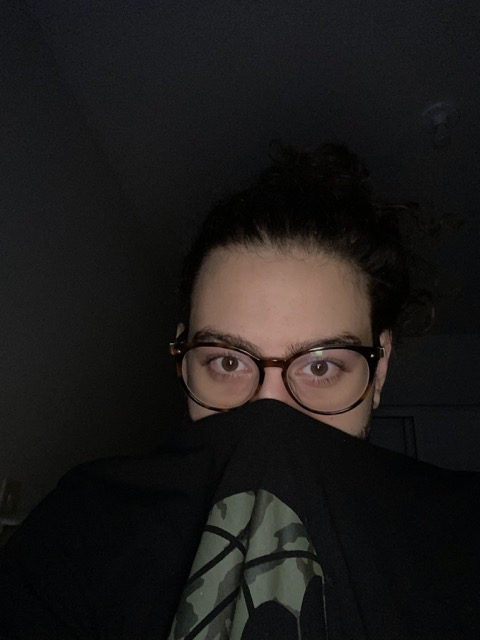

Resultado do Reconhecimento Facial: Gabriel

Top 5 Melhores Resultados:
1. Classe: Gabriel, Score: 0.2032400667667389
2. Classe: Patty_Schnyder, Score: 0.24521684646606445
3. Classe: Hank_Aaron, Score: 0.24680417776107788
4. Classe: Colin_Montgomerie, Score: 0.2520865201950073
5. Classe: Jean-Claude_Braquet, Score: 0.25439444184303284


In [ ]:
new_image_path = '/content/drive/MyDrive/ReconhecimentoFacial/Gabriel_test.jpg'

# Extrair vetor descritor para a nova imagem
new_descriptor = extract_descriptor(new_image_path)

# Realizar o reconhecimento facial na nova imagem
result, top_k_scores = recognize_face_and_return_scores(new_descriptor)

# Exibir a imagem com o resultado e os k melhores scores
display(Image(filename=new_image_path))
print(f"Resultado do Reconhecimento Facial: {result}")

# Exibir a lista dos k melhores scores
print(f"\nTop {len(top_k_scores)} Melhores Resultados:")
for i, (class_name, score) in enumerate(top_k_scores, start=1):
    print(f"{i}. Classe: {class_name}, Score: {score}")